In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import sklearn.metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from kmodes.kmodes import KModes
import numpy as np

In [2]:
from data_quality import cargue_datasets_c
casos, hurto_tp, mede_victimas, compar = cargue_datasets_c()

In [3]:
casos_b=casos
hurto_tp_b=hurto_tp
mede_victimas_b=mede_victimas
compar_b=compar

from data_quality import casos_c
casos=casos_c(casos)

from data_quality import hurto_tp_c
hurto_tp= hurto_tp_c(hurto_tp)

from data_quality import medevic_c
mede_victimas = medevic_c(mede_victimas)

In [5]:
#df = pd.concat([casos_b, hurto_tp_b], axis=0)
#df = df.reset_index(drop=True)
df=hurto_tp_b

In [6]:
columnas_a_eliminar = ['Fecha']

df.drop(columnas_a_eliminar, axis=1, inplace=True)

In [16]:
km = KModes(n_clusters=3, init="Huang", n_init=10,verbose=1)

In [17]:
df.fillna("Desconocido", inplace = True)

In [18]:
df=df.astype(str)

In [19]:
clusters= km.fit_predict(df)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10332, cost: 121332.0
Run 1, iteration: 2/100, moves: 5236, cost: 118583.0
Run 1, iteration: 3/100, moves: 532, cost: 118583.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 9995, cost: 118355.0
Run 2, iteration: 2/100, moves: 1741, cost: 118355.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 5590, cost: 133325.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 7668, cost: 118393.0
Run 4, iteration: 2/100, moves: 1148, cost: 118393.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 7364, cost: 118501.0
Run 5, iteration: 2/100, moves: 214, cost: 118501.0
Init: initializing centroids
Init: initializing clusters
Starting itera

In [20]:
print("Centroides de los clusters")
print(km.cluster_centroids_)
print("Clusters asignados a cada punto de datos:")
print(clusters)

Centroides de los clusters
[['Hombre' '35' 'Soltero(a)' 'Taxi' 'Atraco' 'Sin dato' '10.0'
  'Vía pública' 'Celular' '2018']
 ['Mujer' '27' 'Soltero(a)' 'Autobus' 'Cosquilleo' 'Sin dato' '10.0'
  'Bus de servicio público' 'Celular' '2019']
 ['Hombre' '24' 'Soltero(a)' 'Metro' 'Cosquilleo' 'Sin dato' '10.0'
  'Estación del Metro' 'Celular' '2022']]
Clusters asignados a cada punto de datos:
[0 0 0 ... 0 2 2]


In [21]:
import matplotlib.pyplot as plt
from prince import MCA

In [22]:
df.columns.tolist()

['Sexo',
 'Edad',
 'Estado_civil',
 'Transporte',
 'Modalidad',
 'Conducta',
 'Comuna',
 'Lugar',
 'Bien',
 'Año']

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4722, cost: 128443.0
Run 1, iteration: 2/100, moves: 4102, cost: 127296.0
Run 1, iteration: 3/100, moves: 1208, cost: 127296.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 5790, cost: 129158.0
Run 2, iteration: 2/100, moves: 302, cost: 129158.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 7203, cost: 127087.0
Run 3, iteration: 2/100, moves: 6394, cost: 118579.0
Run 3, iteration: 3/100, moves: 2955, cost: 118579.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 6814, cost: 119779.0
Run 4, iteration: 2/100, moves: 200, cost: 119779.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 8800, cost: 118579.0
Run 5, iteration: 2

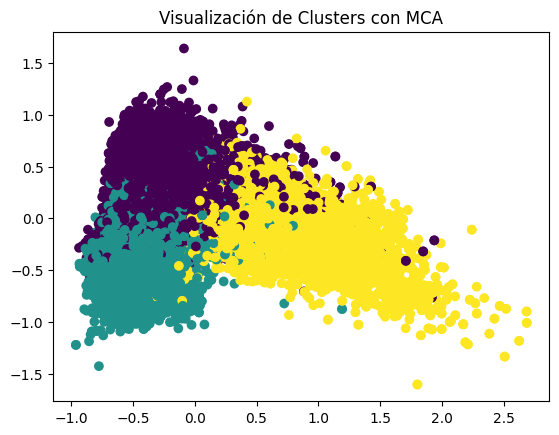

In [23]:
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)

# Ajustar el modelo a los datos
clusters = km.fit_predict(df)

# Aplicar MCA para visualizar los clusters en un espacio de menor dimensión
mca = MCA()
data_mca = mca.fit_transform(df)

# Graficar los clusters en un gráfico bidimensional
plt.scatter(data_mca.values[:, 0], data_mca.values[:, 1], c=clusters, cmap='viridis')
plt.title('Visualización de Clusters con MCA')
plt.show()